In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def print_separator(sep, num, msg):
  print("\n")
  print(sep * num)
  print(f"{msg}")
  print(sep * num)

In [3]:
def unique_values(df, column):
    print_separator('*', 50, "Unique Values")
    unique_vals = df[column].unique()
    try:
        sorted = np.sort(unique_vals)
        print('Sorting succesfull')
        display(list(sorted))
    except TypeError as error:
        print(f'Sorting failed: {error}')
        display(list(unique_vals))

In [4]:
def exploring_data(df, column):
    print_separator('-', 50, f'Checking column #{column}')
    unique_values(df, column)
    print_separator('*', 50, "Value counts")
    display(dict(df[column].value_counts(dropna=False)))

In [5]:
from collections import Counter

def count_activity(df, column):    
    c = Counter()
    df[column] = df[column].str.lower()
    df[column].str.split().apply(c.update)
    return c.most_common()

In [6]:
shark_attacks = pd.read_csv('attacks.csv', encoding='cp1252')
shark_attacks.iloc[0:2].T
shark_attacks.info() #The two columns 'Unnamed' contains only 3 entries in total, highest entry count is 8702 - df runs to 25723
shark_attacks['Unnamed: 22'].unique() #nonsense entry
shark_attacks['Unnamed: 23'].unique() #nonsense entry

#dropping the two columns and rows with only NaN
shark_attacks.dropna(how = 'all', inplace = True)
shark_attacks.drop(columns=['Unnamed: 22', 'Unnamed: 23'], axis=1, inplace=True)

more_20 = shark_attacks.loc[shark_attacks.isnull().sum(axis=1) > 19] #checking for rows with only entries in two columns or less
more_20.info() #only a few entries in Case Number and original order -> not relevant(drop)
shark_attacks.drop(more_20.index, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25723 entries, 0 to 25722
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Case Number             8702 non-null   object 
 1   Date                    6302 non-null   object 
 2   Year                    6300 non-null   float64
 3   Type                    6298 non-null   object 
 4   Country                 6252 non-null   object 
 5   Area                    5847 non-null   object 
 6   Location                5762 non-null   object 
 7   Activity                5758 non-null   object 
 8   Name                    6092 non-null   object 
 9   Sex                     5737 non-null   object 
 10  Age                     3471 non-null   object 
 11  Injury                  6274 non-null   object 
 12  Fatal (Y/N)             5763 non-null   object 
 13  Time                    2948 non-null   object 
 14  Species                 3464 non-null 

Assumption / Bias: 
1. Name of Shark is in front of the word 'Shark' atleast once.
2. Removed cases where shark involvement is questionable
3. If the name of shark contains two seperate words its shortend to the second word
4. The first mentioned name of shark is extracted if there is two shark mentioned
5. If shark names has to be guessed it will be marked as 'Unknown Shark' (ex: blacktipped is prolly blacktip shark)
6. Assumed that Zambesi means Zambezi shark. (Its also a bull shark but not renamed to bullshark)
**What are the most dangerous types of sharks to humans?** 

White shark, Tiger Shark, Bull shark, Blacktip, Nurse

<AxesSubplot:title={'center':'The type of shark most likely to attack humans'}, xlabel='Shark Name', ylabel='Percentage'>

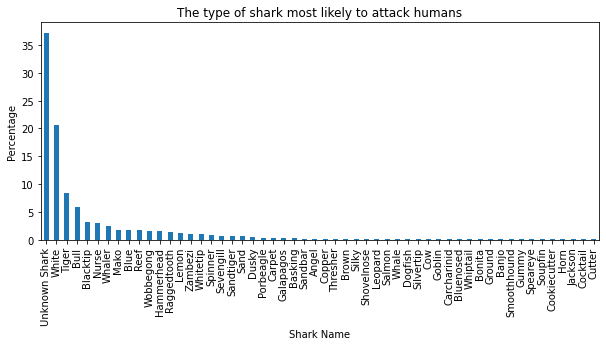

In [74]:
import re

shark_names = shark_attacks.copy()
shark_names.rename(columns={'Species ': 'Species'}, inplace=True)

#Selecting only relevant data with case number
shark_names = shark_names[['Case Number', 'Species']].copy()
shark_names.dropna(subset=['Species'], inplace=True)

#dropping 'questionable shark involvement', 
shark_names.drop(shark_names.loc[shark_names['Species'].str.contains('involvement|Questionable', flags=re.IGNORECASE)].index, inplace=True)

#remove all non-alphabetic letters, extract name in front of shark
shark_names['Only Alpha'] = shark_names['Species'].str.replace('[^a-zA-Z\s]', '', regex=True)
shark_names.loc[shark_names['Species'].str.contains('7-gill')] = 'Sevengill'
shark_names.loc[shark_names['Species'].str.contains('Zambesi')] = 'Zambezi'
shark_names['Only Alpha'] = shark_names['Only Alpha'].str.title()
shark_names['Extract Name'] = shark_names['Only Alpha'].str.extract('(\S+(?=\s+shark|Shark))', flags=re.IGNORECASE)

#clean out extracted names
shark_names['Extract Name'].loc[shark_names['Extract Name'].str.len() < 3] = 'Unknown Shark'
unknown_sharks = ["Small", "Juvenile", "Foot", 'Metre', 'Tipped', "Greycolored", "Captive", "Colored", 
"Finned", 'Young', 'Unidentified', 'Grey',  'Female', 'Two', 'Gaffed', 'Gray', 'Dog','Blackfin', 'For', 
'Browncolored', 'Red', 'Hooked', 'Larger', 'Involve', 'Several', 'Little', 'Large', 'The', 'Saw', 'From', 'Blacktipped', 'Invalid']
shark_names['Extract Name'].replace(unknown_sharks, 'Unknown Shark', inplace=True)

#Second extract including all names without shark following its name
extract_pattern = '|'.join(list(shark_names['Extract Name'].dropna().unique()))
shark_names['Shark Name'] = shark_names['Only Alpha'].str.extract(fr'\b({ extract_pattern })\b', expand=False)
shark_names['Shark Name'].fillna('Unknown Shark', inplace=True)

#convert to percentage and plot bar
perc_shark = shark_names.groupby(['Shark Name']).size() / shark_names.groupby(['Shark Name']).size().sum() * 100
perc_shark.sort_values(inplace=True, ascending=False)
perc_shark.plot(kind='bar', rot=90, figsize=(10,4), title="The type of shark most likely to attack humans", ylabel='Percentage')

<AxesSubplot:title={'center':'Top 10 Sharks that attack humans'}, xlabel='Shark Name', ylabel='Percentage'>

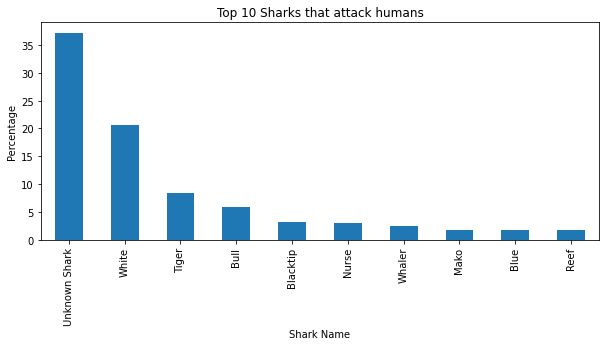

In [73]:
perc_shark.head(10).plot(kind='bar', rot=90, figsize=(10,4), title="Top 10 Sharks that attack humans", ylabel='Percentage')

Assumption / Bias: 
1. There are no human aged >= 100
2. Adults are 18 or older
3. Only one age per cell 
4. There is no relation between the missing data in the  'Age' column with the other columns

**are children more likely to be attacked by sharks?**

No, Adults are more likely to be attacked.

<AxesSubplot:title={'center':'Who is more likely to get attacked'}, xlabel='Age Group', ylabel='Percentage'>

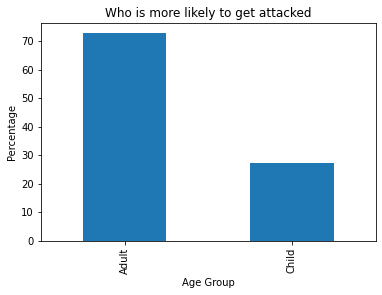

In [67]:
df_age = shark_attacks.loc[:, ['Case Number', 'Species ', 'Age']].copy()
df_age.rename(columns={'Species ': 'Species'}, inplace=True)

#dropping the missing data
df_age.dropna(subset=['Age'], inplace=True)

#extracting digits
df_age['Only AlphaNum'] = df_age['Age'].str.replace('[^a-zA-Z0-9\s]', '', regex=True)
df_age['Only AlphaNum'].loc[df_age['Only AlphaNum'].str.contains('months|teen|young', case=False)] = '1'
df_age['Only AlphaNum'].loc[df_age['Only AlphaNum'].str.contains('adult|middleage|Elderly', case=False)] = '20'
df_age['Numeric'] = df_age['Only AlphaNum'].str.extract('(\d+)')

#clean up remaining data
df_age.dropna(subset=['Numeric'], inplace=True)

#divide up the different ages in two categories
df_age = df_age.astype({'Numeric': 'int'})
df_age['Age Group'] = np.select([df_age['Numeric'] >=18, df_age['Numeric'] <18], ['Adult', 'Child'])

#plot
child_adult = df_age.groupby(['Age Group']).size() / df_age.groupby(['Age Group']).size().sum() *100
child_adult.plot(kind='bar', title='Who is more likely to get attacked', ylabel='Percentage')

Assumption / Bias: 

Decision: 
1. Categorizing [Boat, Boatomg, Boating, 'Sea Disaster', 'Questionable', 'Invalid'] as Invalid 
     * According to https://en.wikipedia.org/wiki/Shark_attack sea disaster is not categorize as provoked or unprovoked but as a seperate category. 
     * Boating or anything with boats should actually be subcategorized as 'provoked or unprovoked' (https://vacationwildlife.com/sharks-attack-boats/) 
2. Injury is not used in analyse.

**Are shark attacks where sharks were provoked more or less dangerous?**

Unprovoked attack are more dangerous with vastly higher chance for fatality, while provoked barely ever leads to death.

<AxesSubplot:title={'center':'Are provoked attacks more dangerous?'}, xlabel='Type of attack', ylabel='Percentage'>

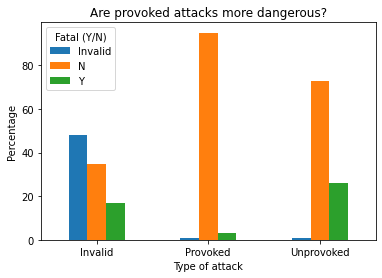

In [9]:
df_provoke = shark_attacks.loc[:, ['Type', 'Fatal (Y/N)']].copy()
df_provoke['Type'].replace({'Boating':'Invalid', 'Questionable':'Invalid', 'Sea Disaster':'Invalid', 'Boat':'Invalid', 'Boatomg':'Invalid', np.nan:'Invalid'}, inplace=True)
df_provoke['Fatal (Y/N)'].replace({np.nan:'Invalid', 'UNKNOWN':'Invalid', ' N':'N', 'N ':'N', 'y': 'Y', 'M':'Invalid', '2017':'Invalid'}, inplace=True)
prove_bar = round(df_provoke.groupby(['Type']).value_counts() / df_provoke.groupby(['Type']).size() * 100).unstack()
prove_bar.plot(kind='bar', title='Are provoked attacks more dangerous?', xlabel='Type of attack', ylabel='Percentage', rot=0)

1. If there is two activity described the one with ending with 'ing' is used. 
2. Only one activity per cell.

**are certain activities more likely to result in a shark attack?**

By far fishing

<AxesSubplot:title={'center':'Activities that provokes shark attacks'}, xlabel='Activity', ylabel='Percentage'>

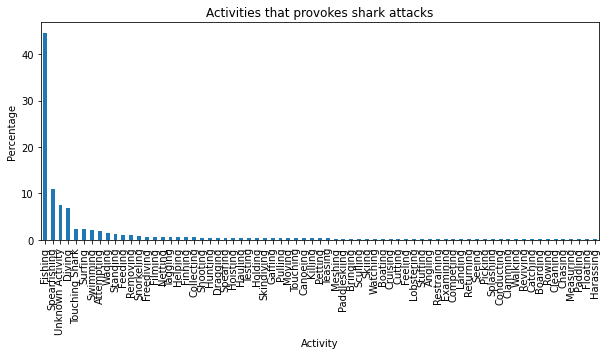

In [75]:
df_activity = shark_attacks.loc[:, ['Activity', 'Type']].copy()
df_activity = df_activity.loc[df_activity['Type'] == 'Provoked'].copy()
df_activity['ing word'] = df_activity['Activity'].str.extract(r'\b(\w+ing)\b', flags=re.IGNORECASE)
df_activity['ing word'] = df_activity['ing word'].str.title()
df_activity.fillna({'Activity':'Unknown Activity', 'ing word':'Unknown Activity'}, inplace=True)
df_activity['ing word'].loc[df_activity['Activity'].str.contains('dead|jump|slap|hand|grab|foot|stood', case=False)] = 'Touching Shark'

#plotting bar
Activity = df_activity['ing word'].value_counts() / df_activity.value_counts().sum() *100
Activity.plot(kind='bar', rot=90, figsize=(10,4), title='Activities that provokes shark attacks', xlabel='Activity', ylabel='Percentage')

<AxesSubplot:title={'center':'Top 10: activities that provokes shark attacks'}, xlabel='Activity', ylabel='Percentage'>

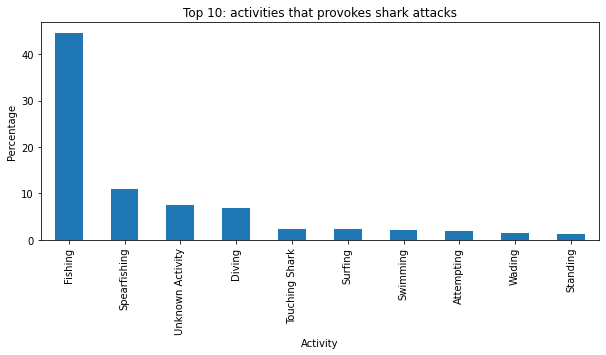

In [77]:
Activity.head(10).plot(kind='bar', rot=90, figsize=(10,4), title='Top 10: activities that provokes shark attacks', xlabel='Activity', ylabel='Percentage')